Любой текст.<br>
Высокая цель: уменшить размерность векторного представления слов текстуальных данных. Построить графики уменьшения размерности. <br>

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from string import punctuation, whitespace
import matplotlib.pyplot as plt
import numpy as np
import spacy


In [ ]:
!python3 -m spacy download en_core_web_sm

1. Загрузка текстового файла из корневого каталога.

In [3]:
text_file_path = 'text-file.txt'

with open(text_file_path, 'r') as file:
    text_data = file.read()


2. Обработка текстовых данных.

In [4]:
# remove all punctuation signs and whitespaces from lowercase text
translator = str.maketrans(whitespace[1:], ' ' * (len(whitespace) - 1))
translator.update(str.maketrans('', '', punctuation))
text_data = text_data.lower().translate(translator).replace('  ', ' ')

# create spacy model for getting words tokens
npl = spacy.load('en_core_web_sm')

# create dictionary with lemma forms for unique words
unique_words = set(text_data.split())
lemma_dict = dict()

for word in unique_words:
    # ignore tokens with stop words and whitespaces
    if word in spacy.lang.en.stop_words.STOP_WORDS or \
        word in whitespace or len(word) == 0:
        continue

    lemma_dict.update({word: npl(word)[0].lemma_})

# replace all words to lemma form
processed_text_list = list()
for word in text_data.split():
    if word in lemma_dict.keys():
        processed_text_list.append(lemma_dict[word])

# update text, create tokens
text_data = ' '.join(processed_text_list)
text_tokens = npl(text_data)


3. Понижение размерности текстовых данных.
4. Построить график объема информации. 

In [5]:
# create list for all tokens words and general vector for they vectors
all_words = [text_tokens[0].text]
all_vectors = text_tokens[0].vector

for token in text_tokens[1:]:
    all_words.append(token.text)
    all_vectors = np.vstack([all_vectors, token.vector])

all_vectors.shape


(201, 96)

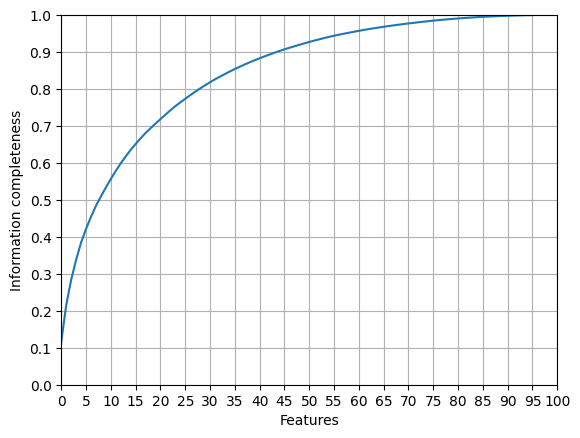

In [6]:
# create PCA object for analze all features
pca = PCA()
X_new = pca.fit_transform(all_vectors)

# calculate cumulative sum for features std
std_sum = np.cumsum(pca.explained_variance_ratio_)

# visualize the completeness of information
plt.plot(std_sum)
plt.grid(True)
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.1))
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
plt.xlabel('Features')
plt.ylabel('Information completeness')
plt.show()


5. Сколько компонент нужно оставить чтобы сохранить 90% информации. 

In [7]:
# get count of features with 90% of information
n_features = np.argmax(std_sum >= 0.9)
print('The number of 90%-informative features is', n_features)


The number of 90%-informative features is 44


6. Попробовать восстановить пару исходных слов. 

In [8]:
# create PCA object for n_features and fit
pca_90 = PCA(n_components=n_features, whiten=True)
X_new_90 = pca_90.fit_transform(all_vectors)

X_new_90.shape


(201, 44)

In [9]:
N_WORDS = 20
transformed_words = list()

# get inversed vectors for first N_WORDS, compare with original words vectors, find the most similar
for x_90 in X_new_90[:N_WORDS]:
    x_inversed = pca_90.inverse_transform(x_90)
    sim_idx = np.argmax(cosine_similarity([x_inversed], all_vectors))

    # add the most similar word to list
    transformed_words.append(all_words[sim_idx])


In [10]:
print('Number of simillar words -', sum(np.array(transformed_words) == text_data.split()[:N_WORDS]), 'from', N_WORDS, '\n')

for [word_initial, word_transformed] in zip(text_data.split()[:N_WORDS], transformed_words):
    print(word_initial, '-', word_transformed)


Number of simillar words - 20 from 20 

detail - detail
story - story
girl - girl
name - name
alice - alice
fall - fall
rabbit - rabbit
hole - hole
fantasy - fantasy
world - world
anthropomorphic - anthropomorphic
creature - creature
see - see
example - example
literary - literary
nonsense - nonsense
genre - genre
artist - artist
john - john
tenniel - tenniel


В результате восстановления N_WORDS первых слов получилось полное совпадение с исходными словами. Вероятно, причиной стала предобработка исходного текста, при которой все слова были заменены исодными формами и убраны стоп-слова, а также малое число слов и размерность векторов слов.<br>
При сокращении количества признаков до 44 из 96 удалось не потерять возможость довольно точного восстановления векторов.